In [ ]:
import pickle
import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

# Loading the Data and Creating the `Dataset` and `DataLoader`

Defining the `Dataset` and `DataLoader`

In [ ]:
class NeuralActivityDataset(Dataset):

    def __init__(self, n_triplets, train_data, train_labels, train, device):

        self.n_triplets = n_triplets
        self.train_data = train_data
        # self.train_data = self.train_data.to(device)
        self.train_triplets = self.generate_triplets(train_labels)
        # self.train_triplets = torch.Tensor(self.train_triplets).to(device)
        self.train = train

    def generate_triplets(self, labels):
        triplets = []

        for n in range(self.n_triplets):
            idx = np.random.randint(0, labels.size(0))

            idx_matches = np.where(labels.numpy() == labels[idx].numpy())[0] # Get the row indices of the matching classes
            idx_no_matches = np.where(labels.numpy() != labels[idx].numpy())[0] # Get the row indices of mismatch classes

            idx_a, idx_p = np.random.choice(idx_matches, 2, replace = False) # returns array consisting of two indices -> ints
            idx_n = np.random.choice(idx_no_matches, 1)[0] # return an index -> int not a numpy array of [int]

            triplets.append([idx_a, idx_p, idx_n])

        return np.array(triplets)

    def __getitem__(self, index):

        if self.train:
            t = self.train_triplets[index]
            a, p, n = self.train_data[t[0]], self.train_data[t[1]], self.train_data[t[2]]

        return a, p, n

    def __len__(self):
        if self.train:
            return self.train_triplets.shape[0]


Loading the Data

In [ ]:
file = open("/content/drive/MyDrive/Deep Learning Project/spike_data/entire_dict.pkl", 'rb')
data = pickle.load(file)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

train_labels = torch.Tensor(np.array(list(data.keys()), dtype=np.float32)[:,1])
train_data = torch.Tensor(np.array(list(data.values()), dtype=np.float32)).transpose(1,2)

Using cuda device


Initializing our `Dataset` and `DataLoader`

In [ ]:
neural_activity_dataset = NeuralActivityDataset(n_triplets=60000, train_data=train_data, train_labels=train_labels, train=True, device=device)

In [ ]:
dataloader = DataLoader(neural_activity_dataset, batch_size=1024, shuffle=True, num_workers=1, pin_memory=True)

# Creating the Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, device, len_seq = 50, num_neurons = 93, d_model = 128, nhead = 4, feed_forward_dim = 1024, num_layers=4, dropout = 0.4, final_embed_dim = 8):
        super().__init__()
        self.num_neurons = num_neurons
        self.embed = d_model
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True,
                                                        dim_feedforward=feed_forward_dim, dropout=dropout, device=device)

        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        self.mlp = nn.Linear(len_seq*d_model, final_embed_dim, device=device)
        self.embedding = nn.Linear(num_neurons, d_model)

    def forward(self, source, train):
        if train:
            embed_in = self.embedding(source)
            transformer_out = self.transformer_encoder(embed_in)
            embeddings = self.mlp(transformer_out.flatten(start_dim = 1))

            # transformer_out_p = self.transformer_encoder(source[1])
            # embeddings_p = self.mlp(transformer_out_p.flatten(start_dim = 1))

            # transformer_out_n = self.transformer_encoder(source[2])
            # embeddings_n = self.mlp(transformer_out_n.flatten(start_dim = 1))

            return embeddings #, embeddings_p, embeddings_n
        else:
            embed_in = self.embedding(source)
            transformer_out = self.transformer_encoder(embed_in)
            embeddings = self.mlp(transformer_out.flatten(start_dim=1))

            return embeddings


# Training the Transformer

Declaring Constants

In [ ]:
# torch.manual_seed(2)

final_embed_dim = 8
transformer_model = TransformerModel(final_embed_dim = final_embed_dim, device=device)
transformer_model.cuda()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 0.001)
epochs = 50
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)

Using cuda device


Defining Training Loop

In [ ]:
def train(epochs, epoch_loss):
    transformer_model.train()
    batch_loss = []
    for batch, (data_a, data_p, data_n) in enumerate(dataloader):
        if device == "cuda":
            data_a, data_p, data_n = data_a.cuda(), data_p.cuda(), data_n.cuda()
        data_a, data_p, data_n = Variable(data_a), Variable(data_p), Variable(data_n)
        optimizer.zero_grad()
        embeddings_a, embeddings_p, embeddings_n = transformer_model(data_a, train = True), transformer_model(data_p, train = True), transformer_model(data_n, train = True)
        loss = triplet_loss(embeddings_a, embeddings_p, embeddings_n)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.cpu().detach().numpy())
    epoch_loss.append(np.mean(batch_loss))

Training the Transformer

In [ ]:
epoch_loss = []
for epoch in tqdm(range(1, epochs+1)):
    train(epoch, epoch_loss)

100%|██████████| 50/50 [30:27<00:00, 36.56s/it]


Saving the Transformer

In [ ]:
torch.save(transformer_model.state_dict(), "/content/drive/MyDrive/Deep Learning Project/transformer_model_transpose_1024.pkl")

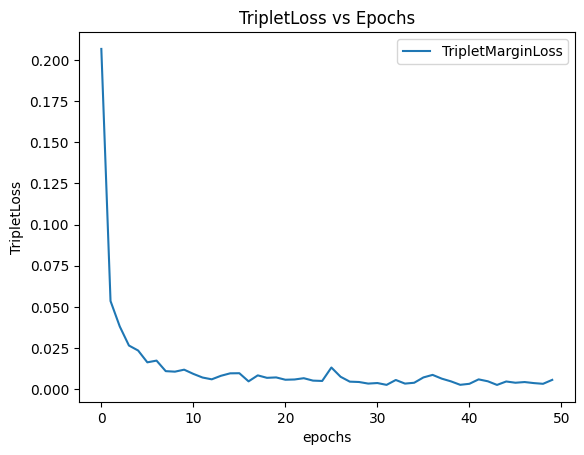

In [ ]:
plt.plot(epoch_loss, label = "TripletMarginLoss")
plt.xlabel("epochs")
plt.ylabel("TripletLoss")
plt.title("TripletLoss vs Epochs")
plt.legend()
plt.show()

In [ ]:
transformer_model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning Project/transformer_model_transpose_1024.pkl"))
transformer_model.eval()

TransformerModel(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=1024, bias=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (linear2): Linear(in_features=1024, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.4, inplace=False)
    (dropout2): Dropout(p=0.4, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=1024, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)


In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_data

    def __getitem__(self, idx):
        return self.test_data[idx], self.test_labels[idx]

    def __len__(self):
        return self.test_labels.shape[0]

test_data, test_labels = train_data, train_labels
test_dataset = TestDataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset)

In [ ]:
def score(model, classifier, dataloader, labels, output_dims):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded = model(data.unsqueeze(0), train=False)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    score = cross_val_score(clf, encodings, labels, scoring="accuracy", cv=5, n_jobs=-1)
    avg_score = score.mean()
    print(f"Average Accuracy: {avg_score}")
    return avg_score

def confusion_matrix(model, classifier, dataloader, labels, output_dims):
    model.eval()
    model = model.to(device)
    encodings = np.empty((1, output_dims))

    for data in dataloader:
        data = data.to(device)
        encoded = model(data.unsqueeze(0), train=False)
        encoded = encoded.detach().cpu().numpy()
        encodings = np.append(encodings, encoded, axis=0)

    encodings = encodings[1:]

    clf = classifier()
    clf.fit(encodings, labels)
    ConfusionMatrixDisplay.from_estimator(clf, encodings, labels)
    plt.show()

def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Mean Squared Error vs. Epochs")
    plt.show()

In [ ]:
score(transformer_model, SVC, test_data, test_labels, final_embed_dim)

Average Accuracy: 0.9981784234757954


0.9981784234757954

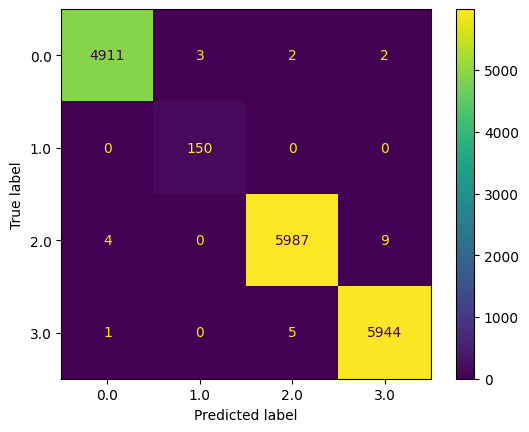

In [ ]:
confusion_matrix(transformer_model, SVC, test_data, test_labels, final_embed_dim)